In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()

from sklearn.linear_model import LinearRegression

from packages.data import get_bike_data
from packages.daylight import hours_of_daylight

In [3]:
data = get_bike_data()

#indexing the data using the start_time
indexed_data = data.set_index('start_time', drop = False)
                              
#resmaples the data to get it in daily and weekly views
daily = indexed_data.resample('d').sum()
daily['count'] = daily['count'].fillna(value = 0)
daily['duration'] = daily['duration'].fillna(value = 0)
                              
weekly = daily.resample('w').sum()  

In [4]:
#manually adds number of Indego stations (couldn't figure out easier way)
daily['num_stations'] = 120
daily['num_stations'][daily.index < '2017-06-09'] = 118
daily['num_stations'][daily.index < '2017-06-08'] = 115
daily['num_stations'][daily.index < '2017-06-07'] = 112
daily['num_stations'][daily.index < '2017-06-06'] = 109
daily['num_stations'][daily.index < '2017-06-05'] = 107
daily['num_stations'][daily.index < '2016-05-24'] = 106
daily['num_stations'][daily.index < '2016-05-06'] = 104
daily['num_stations'][daily.index < '2016-05-05'] = 100
daily['num_stations'][daily.index < '2016-05-04'] = 96
daily['num_stations'][daily.index < '2016-05-03'] = 92
daily['num_stations'][daily.index < '2016-05-02'] = 88
daily['num_stations'][daily.index < '2016-04-29'] = 86
daily['num_stations'][daily.index < '2016-04-28'] = 84
daily['num_stations'][daily.index < '2016-04-27'] = 82
daily['num_stations'][daily.index < '2016-04-26'] = 80
daily['num_stations'][daily.index < '2016-04-25'] = 78
daily['num_stations'][daily.index < '2016-04-15'] = 77
daily['num_stations'][daily.index < '2016-04-08'] = 76
daily['num_stations'][daily.index < '2016-03-31'] = 75
daily['num_stations'][daily.index < '2015-10-20'] = 74
daily['num_stations'][daily.index < '2015-07-31'] = 73
daily['num_stations'][daily.index < '2015-06-10'] = 72
daily['num_stations'][daily.index < '2015-04-29'] = 67
daily['num_stations'][daily.index < '2015-04-28'] = 62

/Users/brandonkalnasy/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/brandonkalnasy/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/brandonkalnasy/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#inde

In [40]:
#Shows the days with the most rides
#daily.nlargest(20, 'count')

#daily highs are around Pope visit in Sept 2015, Septa strike in Nov 2016, NFL draft in late April 2017, 
#and June 2017 (most recent month in data)
#Obama visit on 9-13-2016 


In [6]:
#daily['count'].plot()
#plt.ylabel('Daily riders')

In [7]:
#daily['duration'].plot()
#plt.ylabel('Daily Time Ridden');

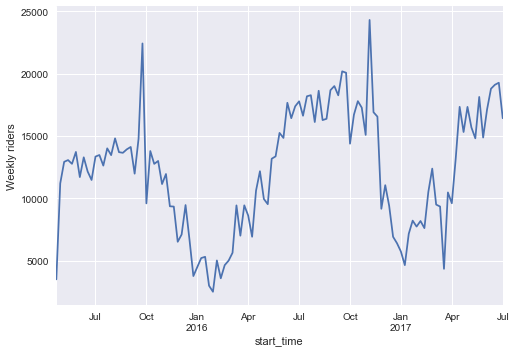

In [8]:
weekly['count'].plot()
plt.ylabel('Weekly riders');

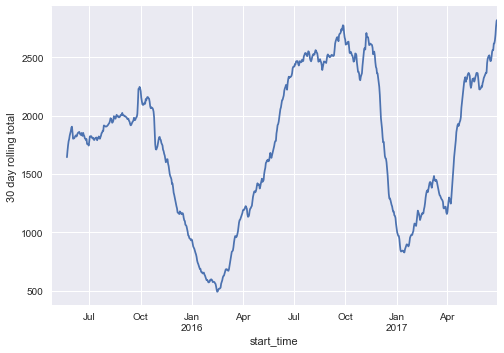

In [10]:
daily['count'].rolling(window = 30).mean().plot()
plt.ylabel('30 day rolling total');

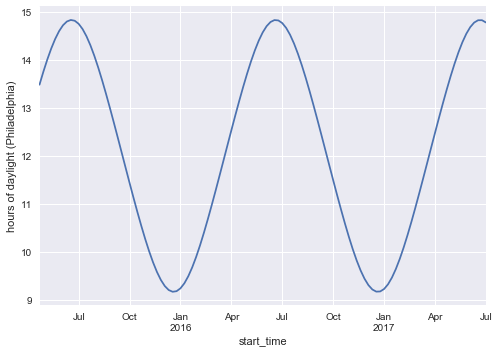

In [11]:
#maps the hours_of_daylight function with the dates
weekly['daylight']=list(map(hours_of_daylight, weekly.index))
daily['daylight'] = list(map(hours_of_daylight, daily.index))

# Plot the daylight curve
weekly['daylight'].plot()
plt.ylabel('hours of daylight (Philadelphia)');

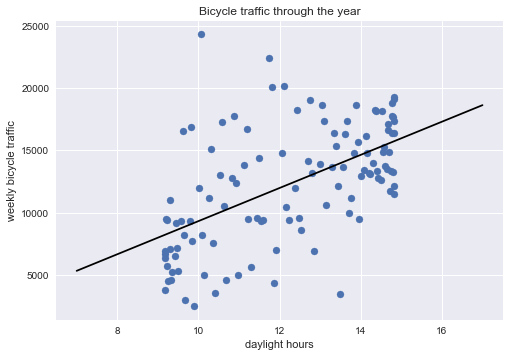

In [13]:
#creates linear model to predict number of riders from hours of daylight
X = weekly[['daylight']]
y = weekly['count']
clf = LinearRegression(fit_intercept=True).fit(X, y)

xfit = np.linspace(7, 17)
yfit = clf.predict(xfit[:, None])
plt.scatter(weekly['daylight'], weekly['count'])
plt.plot(xfit, yfit, '-k')
plt.title("Bicycle traffic through the year")
plt.xlabel('daylight hours')
plt.ylabel('weekly bicycle traffic');

In [14]:
#For every extra hour of sunlight this is the expected increase in weekly riders
print('For every extra hour of sunlight, the expected increase in weekly risers is: ')
print(clf.coef_[0])

For every extra hour of sunlight, the expected increase in weekly risers is: 
1328.01399997


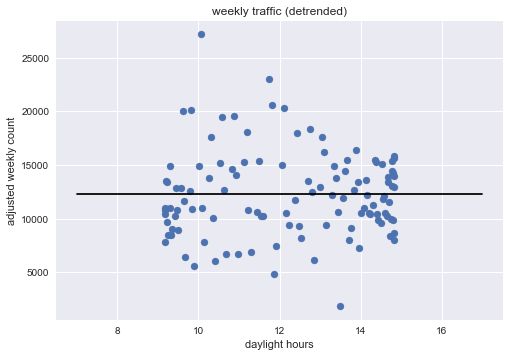

In [15]:
#this creates a 'de-trended' view of hours of daylight vs number of riders
#this is done by subtracting the 'trend', which correlates the hours of daylight with the number of riders,
#and replacing it with the mean

trend = clf.predict(weekly[['daylight']].as_matrix())
plt.scatter(weekly['daylight'], weekly['count'] - trend + np.mean(trend))
plt.plot(xfit, np.mean(trend) + 0 * yfit, '-k')
plt.title("weekly traffic (detrended)")
plt.xlabel('daylight hours')
plt.ylabel('adjusted weekly count');

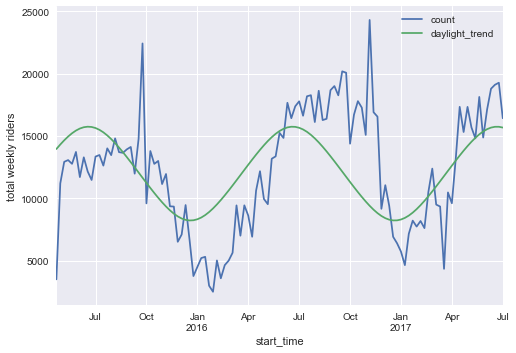

In [16]:
#plots the weekly riders along the expected riders using the daylight trend
weekly['daylight_trend'] = clf.predict(X)

weekly[['count', 'daylight_trend']].plot()
plt.ylabel("total weekly riders");

root-mean-square about trend: 3981 riders


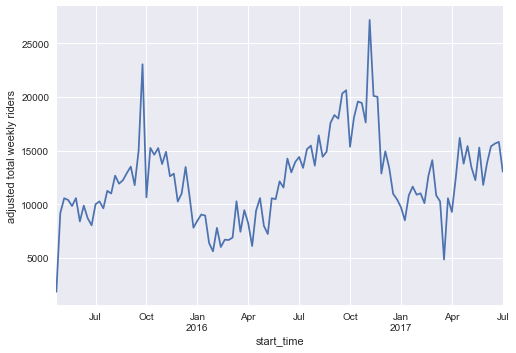

In [17]:
#similar to above, I subtract the hours of daylight trend and replace it with the mean
weekly['daylight_corrected_total'] = weekly['count'] - weekly['daylight_trend'] + weekly['daylight_trend'].mean()

weekly['daylight_corrected_total'].plot()
plt.ylabel("adjusted total weekly riders")

rms = np.std(weekly['daylight_corrected_total'])
print("root-mean-square about trend: {0:.0f} riders".format(rms));

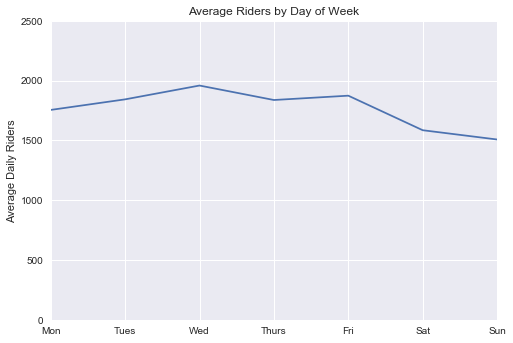

In [18]:
#adding days of week to daily data
days = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
daily['dayofweek'] = daily['count'].index.dayofweek
#creates grouped data by day of week and plots average daily riders 
grouped = daily.groupby('dayofweek')['count'].mean()
grouped.index = days

grouped.plot()
plt.title('Average Riders by Day of Week')
plt.ylabel('Average Daily Riders')
plt.ylim(0, 2500);

#not showing too much of drop between weekdays and weekends

In [19]:
# Add one-hot indicators of weekdays
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

,trip_id,duration,start_station_id,end_station_id,plan_duration,count,num_stations,daylight,dayofweek,Mon,Tues,Wed,Thurs,Fri,Sat,Sun
start_time,,,,,,,,,,,,,,,,
2015-04-23,1.596942e+09,19614.0,1210810.0,1211773.0,17215.0,399.0,62,13.361245,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2015-04-24,2.906283e+09,32291.0,2203701.0,2203175.0,30170.0,726.0,62,13.402089,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2015-04-25,4.441658e+09,50605.0,3366249.0,3365542.0,39055.0,1109.0,62,13.442647,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2015-04-26,5.140775e+09,73376.0,3896756.0,3897993.0,48450.0,1283.0,62,13.482907,6,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2015-04-27,3.278567e+09,31028.0,2482198.0,2482990.0,30145.0,818.0,62,13.522857,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-04-28,4.803145e+09,42423.0,3639154.0,3638927.0,42940.0,1198.0,67,13.562484,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2015-04-29,5.993181e+09,54944.0,4537869.0,4538741.0,51150.0,1494.0,72,13.601775,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0


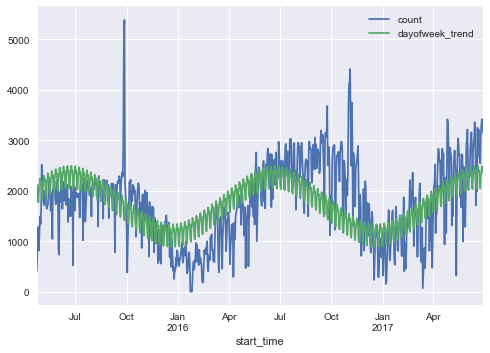

In [20]:
# de-trend data from days of the week and daylight together
X = daily[days + ['daylight']]
y = daily['count']
clf = LinearRegression().fit(X, y)

#plots the daylight/day of week trend next to the daily rider count
daily['dayofweek_trend'] = clf.predict(X)
daily[['count', 'dayofweek_trend']].plot();

rms = 668


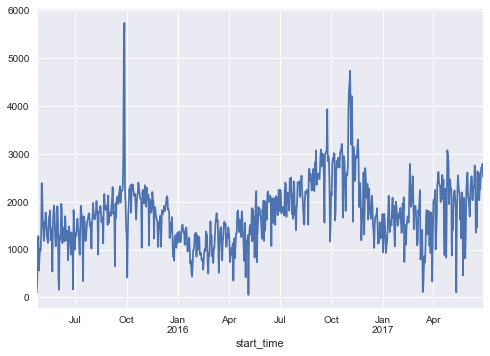

In [21]:
#corrects the day of week/daylight value by subtracting the trend and replacing with mean

daily['dayofweek_corrected'] = (daily['count'] - daily['dayofweek_trend'] + daily['dayofweek_trend'].mean())
daily['dayofweek_corrected'].plot()
print("rms = {0:.0f}".format(np.std(daily['dayofweek_corrected'])))

#this plot corrects for daily and annual trends (ie. day of week, hours or daylight)

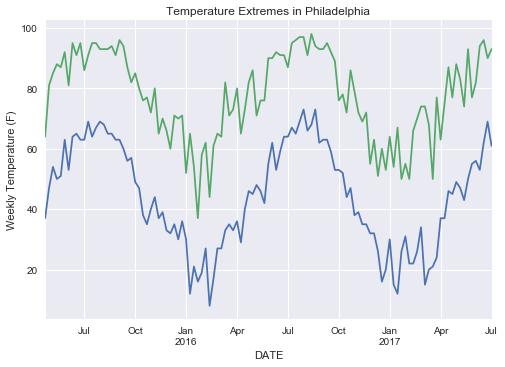

In [22]:
#Reads the weather data
weather = pd.read_csv('phlweather.csv', index_col='DATE', parse_dates=True, usecols=[2, 3, 4, 8, 9, 10])
#drops the dates after 2017Q2 that we don't need
weather = weather[:'2017-06-30']

#plots min and max weekly temps
weather['TMIN'].resample('w').min().plot()
weather['TMAX'].resample('w').max().plot()
#weather['TAVG'].resample('w').mean().plot()
plt.ylabel('Weekly Temperature (F)');
plt.title('Temperature Extremes in Philadelphia');


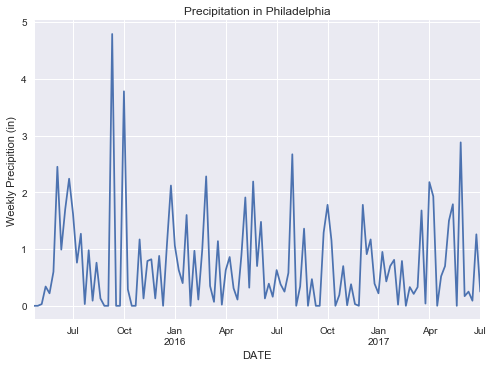

In [23]:
#plots weekly precipitation 

weather['PRCP'].resample('w').sum().plot()
plt.ylabel('Weekly Precipition (in)')
plt.title('Precipitation in Philadelphia')

In [24]:
# join the weather data to daily data
daily = daily.join(weather)

#one year of data
daily = daily['2016-07-01':]
daily['average_duration'] = daily['duration'] / daily['count']


In [25]:
daily.head()

,trip_id,duration,start_station_id,end_station_id,plan_duration,count,num_stations,daylight,dayofweek,Mon,...,Sat,Sun,dayofweek_trend,dayofweek_corrected,AWND,PRCP,TAVG,TMAX,TMIN,average_duration
start_time,,,,,,,,,,,,,,,,,,,,,
2016-07-01,6.199355e+10,51832.0,7434814.0,7429867.0,72130.0,2438.0,107,14.785499,4,0.0,...,0.0,0.0,2399.538207,1804.674293,7.38,0.00,77.0,87.0,70.0,21.260049
2016-07-02,6.716450e+10,81167.0,7917520.0,7915166.0,67105.0,2594.0,107,14.775659,5,0.0,...,1.0,0.0,2112.908569,2247.303931,12.30,0.00,75.0,80.0,70.0,31.290285
2016-07-03,6.350215e+10,77896.0,7358339.0,7356019.0,59415.0,2410.0,107,14.764875,6,0.0,...,0.0,1.0,2032.749044,2143.463456,7.16,0.00,73.0,78.0,67.0,32.321992
2016-07-04,6.065749e+10,79029.0,6911092.0,6906174.0,54150.0,2264.0,107,14.753157,0,1.0,...,0.0,0.0,2277.287583,1752.924917,7.61,0.29,73.0,80.0,67.0,34.906802
2016-07-05,6.546435e+10,52348.0,7314922.0,7316258.0,70605.0,2400.0,107,14.740511,1,0.0,...,0.0,0.0,2362.666453,1803.546047,9.84,0.08,78.0,89.0,74.0,21.811667


0.714039791566


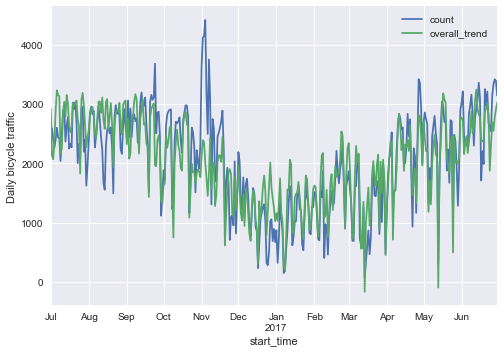

In [26]:
columns = days + ['daylight', 'AWND', 'TMIN', 'TMAX', 'PRCP']

#creates linear model using day of week and weather factors to predict number of riders
X = daily[columns]
y = daily['count']
clf = LinearRegression().fit(X, y)
daily['overall_trend'] = clf.predict(X)

# Plot the overall trend
daily[['count', 'overall_trend']].plot()
plt.ylabel('Daily bicycle traffic')

print(clf.score(X,y))

rms = 451


(0, 5000)

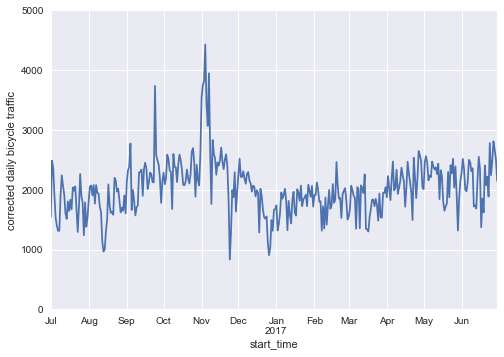

In [27]:
#subtracts trend from count and replaces with mean

daily['overall_corrected'] = daily['count'] - daily['overall_trend'] + daily['overall_trend'].mean()
print("rms = {0:.0f}".format(np.std(daily['overall_corrected'])))
daily['overall_corrected'].plot()
plt.ylabel('corrected daily bicycle traffic')
plt.ylim(0,5000)

(0, 3000)

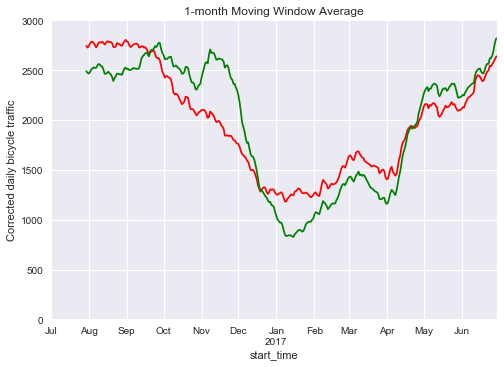

In [28]:
daily['overall_trend'].rolling(window = 30).mean().plot(color='red')
daily['count'].rolling(window = 30).mean().plot(color = 'green')
plt.ylabel('Corrected daily bicycle traffic')
plt.title('1-month Moving Window Average')
plt.ylim(0,3000)

0.718173296863


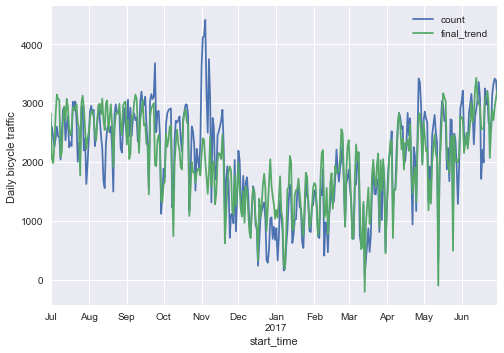

In [29]:
#add the day index to account for overall increase/decrease in riders overtime and adds bike share number of stations
daily['daycount'] = np.arange(len(daily))

columns = days + ['daylight', 'AWND', 'TMIN', 'TMAX', 'PRCP', 'daycount','num_stations']

#creates linear model using day of week and weather factors to predict number of riders
X = daily[columns]
y = daily['count']
final_model = LinearRegression().fit(X, y)
daily['final_trend'] = final_model.predict(X)

# Plot the overall trend
daily[['count', 'final_trend']].plot()
plt.ylabel('Daily bicycle traffic')
print(final_model.score(X,y))

rms = 448


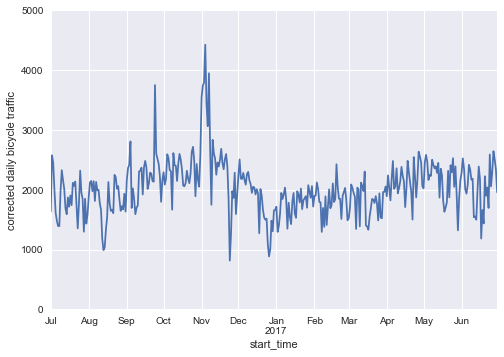

In [30]:
#subtracts trend from count and replaces with mean

daily['final_corrected'] = daily['count'] - daily['final_trend'] + daily['final_trend'].mean()
print("rms = {0:.0f}".format(np.std(daily['final_corrected'])))
daily['final_corrected'].plot()
plt.ylabel('corrected daily bicycle traffic')
plt.ylim(0,5000);

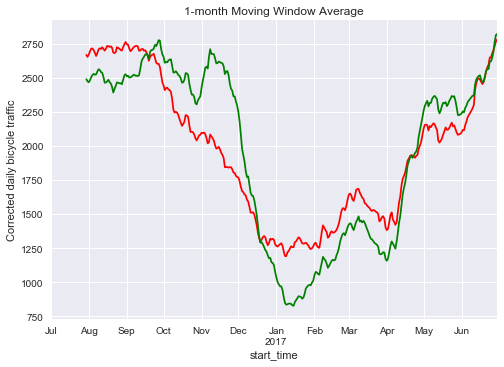

In [31]:
daily['final_trend'].rolling(window = 30).mean().plot(color='red')
daily['count'].rolling(window = 30).mean().plot(color = 'green')
plt.ylabel('Corrected daily bicycle traffic')
plt.title('1-month Moving Window Average');

In [32]:
vy = np.sum((y - daily['final_trend']) ** 2) / len(y)
X2 = np.hstack([X, np.ones((X.shape[0], 1))])
C = vy * np.linalg.inv(np.dot(X2.T, X2))
var = C.diagonal()

In [33]:
ind = columns.index('PRCP')
slope = final_model.coef_[ind]
error = np.sqrt(var[ind])
print("{0:.0f} +/- {1:.0f} daily riders lost per inch of rain".format(-slope, error))

773 +/- 87 daily riders lost per inch of rain


In [34]:
ind1, ind2 = columns.index('TMIN'), columns.index('TMAX')
slope = final_model.coef_[ind1] + final_model.coef_[ind2]
error = np.sqrt(var[ind1] + var[ind2])
print('{0:.0f} +/- {1:.0f} daily riders per ten degrees Fahrenheit'.format(10 * slope, 10 * error))

318 +/- 65 daily riders per ten degrees Fahrenheit


In [35]:
ind = columns.index('daylight')
slope = final_model.coef_[ind]
error = np.sqrt(var[ind])
print("{0:.0f} +/- {1:.0f} daily crossings gained per hour of daylight".format(slope, error))

-1 +/- 23 daily crossings gained per hour of daylight


In [36]:
ind = columns.index('num_stations')
slope = final_model.coef_[ind]
error = np.sqrt(var[ind])
print("{0:.2f} +/- {1:.2f} new riders per new station".format(slope, error))

12.79 +/- 9.48 new riders per new station


In [37]:
ind = columns.index('daycount')
slope = final_model.coef_[ind]
error = np.sqrt(var[ind])
print("{0:.2f} +/- {1:.2f} new riders per day".format(slope, error))
print("{0:.1f} +/- {1:.1f} new riders per week".format(7 * slope, 7 * error))
print("annual change: ({0:.0f} +/- {1:.0f})%".format(100 * 365 * slope / daily['count'].mean(),
                                                    100 * 365 * error / daily['count'].mean()))

0.31 +/- 0.35 new riders per day
2.2 +/- 2.5 new riders per week
annual change: (6 +/- 6)%
